# Get analysis efficiency from scanning $\alpha_{sky}$ parameter space

### June 17, 2020

We have the parameter $\alpha_{sky}$ that tells us what fraction of the background events are taken out by constraining the fraction of sky that we expect Cen A events to come from. 

We can get the SNR intercept change by assuming that the background events for the source search will follow a similar distribution as in the diffuse analysis:
\begin{equation}
\text{SNR}_{new}-\text{SNR}_{old} = -\frac{\log(\alpha_{sky})}{b},
\end{equation}
where
$$
\alpha_{sky} \equiv \frac{\Delta \cos(\theta_{reco})\Delta\phi_{reco}}{(2)(2\pi)}, \qquad b = -5.96
$$
is the fraction of sky that we constraint from simulations.

We want to see how the efficiency changes as a function of $\alpha_{sky}$ so we can set a goal in terms of efficiency improvement.

## Code

### Import needed packages

In [1]:
import sys
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd

Welcome to JupyROOT 6.18/04


### Get data from ROOT files

In [2]:
file_list=[]#Define an empty list
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/"):#Loop over desired directory
    if filename.endswith(".root"): #extension, .root in this case
        file_list.append(os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/", str(filename))) #add file name to the list
        
        

In [3]:
chain = TChain("allCuts") #Define chain and tree that needs to be read. "allCuts" in this case.
for line in file_list:
    chain.AddFile(line)

In [4]:
corr_val = [[],[]]
snr_val = [[],[]]
# failsRcut_V = []
# failsRcut_H = []
# this_y_val = [[],[]]
weight = []
energy = []
failsTopV = []
failsTopH = []
isSurface = []
# peakTheta_300m = []
# peakPhi_300m = []
for entry in chain:
#     if(entry.peakCorr_single[0]<0.01): continue
#     if(entry.peakPhi_single[0]<0):
#         phi.append(entry.peakPhi_single[0]+180) #extract variables of interest
#     else:
    corr_val[0].append(entry.corr_val[0]) 
    corr_val[1].append(entry.corr_val[1]) 
    snr_val[0].append(entry.snr_val[0]) 
    snr_val[1].append(entry.snr_val[1]) 

#     failsRcut_V.append(entry.failsRcut[0])
#     failsRcut_H.append(entry.failsRcut[1])
    failsTopV.append(entry.failsTopV)
    failsTopH.append(entry.failsTopH)
    isSurface.append(entry.isSurface)

    
#     this_y_val[0].append(entry.this_y_val[0])
#     this_y_val[1].append(entry.this_y_val[1])
    weight.append(entry.weight)
    energy.append(entry.energy)
#     peakTheta_300m.append(entry.peakTheta_300m[0]+90)
#     peakPhi_300m.append(entry.peakPhi_300m[0])

Error in <TFile::ReadBuffer>: error reading all requested bytes from file /users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/allCuts_seed_0_run_0.root, got 290 of 300
Error in <TFile::Init>: /users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/allCuts_seed_0_run_0.root failed to read the file type data.


### Let's first bin up the energies

In [6]:
d = {'energy':np.array(energy),'snrV':np.array(snr_val[0]),'snrH':np.array(snr_val[1]),'corrV':np.array(corr_val[0]),'corrH':np.array(corr_val[1]), "failsTopV":np.array(failsTopV), "failsTopH":np.array(failsTopH), "isSurface":np.array(isSurface)}
cuts = pd.DataFrame(data=d)
# cuts["failsCut"] = ((cuts.failsCutV==1) & (cuts.failsCutH==1))
cuts["failsTopCut"] = ((cuts.failsTopV==1) | (cuts.failsTopH==1))

# cuts["passes"] = ((cuts.failsCut==False) & (cuts.failsTopCut==False) & (cuts.isSurface==False))
# cuts.energy.value_counts()
cuts.head()

,energy,snrV,snrH,corrV,corrH,failsTopV,failsTopH,isSurface,failsTopCut
0,5.724450e+17,5.266871,2.986371,0.005361,0.003016,1,1,1,True
1,7.536998e+16,5.756939,3.596876,0.006587,0.003141,0,0,0,False
2,1.427773e+18,8.434304,3.819788,0.010894,0.002987,0,1,1,True
3,1.754024e+18,10.980052,3.509882,0.014154,0.003044,0,0,1,False
4,2.848059e+18,40.007315,27.396415,0.029302,0.025100,0,0,0,False


In [7]:
forBins_half = np.logspace(15.5, 20.5, num=6)
forBins_half

array([3.16227766e+15, 3.16227766e+16, 3.16227766e+17, 3.16227766e+18,
       3.16227766e+19, 3.16227766e+20])

In [8]:
forBins = np.logspace(15, 20, num=6)
forBins

array([1.e+15, 1.e+16, 1.e+17, 1.e+18, 1.e+19, 1.e+20])

In [9]:
Ebins = np.concatenate([forBins_half,forBins])
Ebins = np.sort(Ebins)

In [10]:
cuts["binnedE"] = pd.cut(cuts.energy, bins=Ebins, labels=Ebins[1:]).astype(float)

In [11]:
cuts.head()

,energy,snrV,snrH,corrV,corrH,failsTopV,failsTopH,isSurface,failsTopCut,binnedE
0,5.724450e+17,5.266871,2.986371,0.005361,0.003016,1,1,1,True,1.000000e+18
1,7.536998e+16,5.756939,3.596876,0.006587,0.003141,0,0,0,False,1.000000e+17
2,1.427773e+18,8.434304,3.819788,0.010894,0.002987,0,1,1,True,3.162278e+18
3,1.754024e+18,10.980052,3.509882,0.014154,0.003044,0,0,1,False,3.162278e+18
4,2.848059e+18,40.007315,27.396415,0.029302,0.025100,0,0,0,False,3.162278e+18


### Can now bin up the SNRs

In [12]:
SNR_bins = np.linspace(0,45,45)
# SNR_bins
cuts["binnedSNR"] = pd.cut(cuts.snrV, bins=SNR_bins, labels=SNR_bins[1:]).astype(float)

In [13]:
cuts.head()

,energy,snrV,snrH,corrV,corrH,failsTopV,failsTopH,isSurface,failsTopCut,binnedE,binnedSNR
0,5.724450e+17,5.266871,2.986371,0.005361,0.003016,1,1,1,True,1.000000e+18,6.136364
1,7.536998e+16,5.756939,3.596876,0.006587,0.003141,0,0,0,False,1.000000e+17,6.136364
2,1.427773e+18,8.434304,3.819788,0.010894,0.002987,0,1,1,True,3.162278e+18,9.204545
3,1.754024e+18,10.980052,3.509882,0.014154,0.003044,0,0,1,False,3.162278e+18,11.250000
4,2.848059e+18,40.007315,27.396415,0.029302,0.025100,0,0,0,False,3.162278e+18,40.909091


### The code below will be an iterative function that returns the expected efficiency for each value of $\alpha_{sky}$

An event will pass the cut if 
$$
SNR_{pol} > m_{pol}\times C_{sky,pol} + SNR_{0,pol}
$$
where
$$
SNR_{0,V} = 20.6, \quad m_V = -2080 \\
SNR_{0,H} = 12.7, \quad m_H = -640
$$
$\text{SNR}_{new}-\text{SNR}_{old} = -\frac{\log(\alpha_{sky})}{b}$


In [83]:
diffuseEff = pd.read_csv("./data/diffuse_eff.txt")
diffuseEff_OSU = pd.read_csv("./data/diffuse_eff_OSU.txt")

def loop_alpha(alpha, m=np.array([-2080,-640]), SNR_0 = np.array([20.6,12.7]), b = -5.96):
    SNR_new = np.array([SNR_0[0]-np.log(alpha)/b, SNR_0[1]])
    print(np.log(alpha)/b)
    cuts["failsRCut"] = (cuts.snrV < m[0]*cuts["corrV"]+SNR_new[0]) & (cuts.snrH < m[1]*cuts["corrH"]+SNR_new[1])
    cuts["passes"] = (cuts.failsTopCut == False) & (cuts.isSurface == False) & (cuts.failsRCut == False)
    total_num = cuts.binnedE.value_counts(sort=False)
    total_num=total_num.sort_index()
    forEff = pd.DataFrame(data = total_num)
    forEff.index.name = 'Energy'
    passesCuts = cuts.loc[cuts.passes == True].binnedE.value_counts()
    passesCuts = passesCuts.sort_index()
    forEff["passesCuts"]=passesCuts
    forEff.passesCuts=forEff.passesCuts.fillna(0)
#     print(forEff.passesCuts)
    return 100*forEff.passesCuts/forEff.binnedE
eff = loop_alpha(100.03/(360*2))

0.33117132063976706


0.1
1.4902409907725078
1
1.103901210068809
10
0.7175614293651099
100
0.331221648661411
300
0.14689072774394293


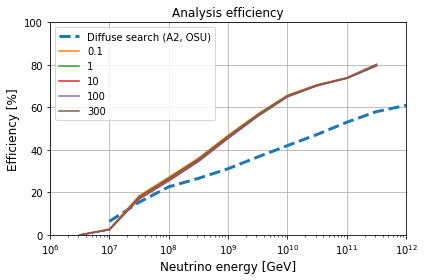

In [85]:
plt.plot(np.power(10,diffuseEff_OSU.E)/1E9, 100*diffuseEff_OSU["a2_eff"],"--", linewidth = 3, label = "Diffuse search (A2, OSU)")
for sky_constraint in [0.1,1, 10, 100, 300]:
    print(sky_constraint)
    eff = loop_alpha(sky_constraint/(360*2))
    plt.plot(forEff.index/1E9, eff, label = sky_constraint)


plt.xscale('log')
plt.xlabel("Neutrino energy [GeV]", fontsize=12)
plt.ylabel("Efficiency [%]", fontsize=12)
plt.title("Analysis efficiency")
plt.xlim(1E6,1E12)
plt.ylim(0,100)

plt.grid()
plt.legend()
plt.tight_layout()

In [53]:
m=np.array([-2080,-640])
SNR_0 = np.array([20.6,12.7])
b = -5.96
cuts["failsRCut"] = (cuts.snrV < m[0]*cuts["corrV"]+SNR_new[0]) & (cuts.snrH < m[1]*cuts["corrH"]+SNR_new[1])
cuts["passes"] = (cuts.failsTopCut == False) & (cuts.isSurface == False) & (cuts.failsRCut == False)



In [54]:
cuts.head()

,energy,snrV,snrH,corrV,corrH,failsTopV,failsTopH,isSurface,failsTopCut,binnedE,binnedSNR,failsRCut,passes
0,5.724450e+17,5.266871,2.986371,0.005361,0.003016,1,1,1,True,1.000000e+18,6.136364,True,False
1,7.536998e+16,5.756939,3.596876,0.006587,0.003141,0,0,0,False,1.000000e+17,6.136364,True,False
2,1.427773e+18,8.434304,3.819788,0.010894,0.002987,0,1,1,True,3.162278e+18,9.204545,False,False
3,1.754024e+18,10.980052,3.509882,0.014154,0.003044,0,0,1,False,3.162278e+18,11.250000,False,False
4,2.848059e+18,40.007315,27.396415,0.029302,0.025100,0,0,0,False,3.162278e+18,40.909091,False,True


### Get the efficiencies per energy

In [55]:
total_num = cuts.binnedE.value_counts(sort=False)
total_num=total_num.sort_index()
forEff = pd.DataFrame(data = total_num)
forEff.index.name = 'Energy'
# forEff.index

In [56]:
passesCuts = cuts.loc[cuts.passes == True].binnedE.value_counts()
passesCuts = passesCuts.sort_index()
forEff["passesCuts"]=passesCuts
passesCuts

1.000000e+16       7
3.162278e+16     178
1.000000e+17     868
3.162278e+17    2137
1.000000e+18    3153
3.162278e+18    3355
1.000000e+19    2712
3.162278e+19    1503
1.000000e+20     652
3.162278e+20     306
Name: binnedE, dtype: int64

In [57]:
forEff.passesCuts=forEff.passesCuts.fillna(0)
forEff.head()

,binnedE,passesCuts
Energy,,
3.162278e+15,103,0.0
1.000000e+16,278,7.0
3.162278e+16,1062,178.0
1.000000e+17,3450,868.0
3.162278e+17,6195,2137.0


### Energies are binned up, let's calculate the efficiency

In [58]:
diffuseEff = pd.read_csv("./data/diffuse_eff.txt")
diffuseEff_OSU = pd.read_csv("./data/diffuse_eff_OSU.txt")
diffuseEff.head()

,energy,eff
0,11300000.0,0.0688
1,18200000.0,0.1100
2,28800000.0,0.1490
3,39600000.0,0.1820
4,60900000.0,0.2090


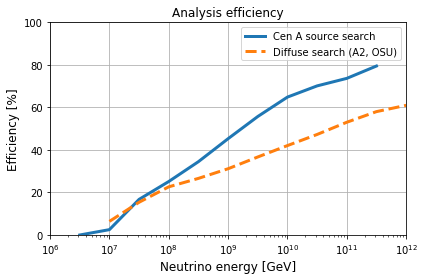

In [59]:
plt.plot(forEff.index/1E9, 100*forEff.passesCuts/forEff.binnedE,linewidth = 3, label = "Cen A source search")
plt.plot(np.power(10,diffuseEff_OSU.E)/1E9, 100*diffuseEff_OSU["a2_eff"],"--", linewidth = 3, label = "Diffuse search (A2, OSU)")

plt.xscale('log')
plt.xlabel("Neutrino energy [GeV]", fontsize=12)
plt.ylabel("Efficiency [%]", fontsize=12)
plt.title("Analysis efficiency")
plt.xlim(1E6,1E12)
plt.ylim(0,100)

plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/CenA_search_efficiency_OSU.png", dpi=200) 

### Efficiencies as a function of SNR

In [50]:
total_num = cuts.binnedSNR.value_counts(sort=False)
total_num=total_num.sort_index()
forEff_SNR = pd.DataFrame(data = total_num)
forEff_SNR.index.name = 'SNR'
forEff_SNR.head()

,binnedSNR
SNR,
3.068182,2
4.090909,1727
5.113636,5826
6.136364,3811
7.159091,2511


In [51]:
passesCuts_SNR = cuts.loc[cuts.passes == True].binnedSNR.value_counts()
passesCuts_SNR = passesCuts_SNR.sort_index()
forEff_SNR["passesCuts_SNR"]=passesCuts_SNR
forEff_SNR.passesCuts_SNR=forEff_SNR.passesCuts_SNR.fillna(0)
forEff_SNR.head()

,binnedSNR,passesCuts_SNR
SNR,,
3.068182,2,0.0
4.090909,1727,7.0
5.113636,5826,69.0
6.136364,3811,526.0
7.159091,2511,1160.0


In [69]:
diffuse_EffSNR = pd.read_csv("./data/Eff_vs_SNR.txt")
diffuse_EffSNR_Brian = pd.read_csv("./data/Eff_vs_SNR_Brian.txt")

diffuse_EffSNR.head()

,snr,a2_eff,a2_err,a3_eff,a3_err
0,4.0,0.0004,0.0001,0.0006,0.0002
1,5.0,0.0112,0.0009,0.0068,0.0006
2,6.0,0.0939,0.0033,0.0944,0.0031
3,7.0,0.2905,0.0073,0.2884,0.0069
4,8.0,0.4719,0.0114,0.3603,0.0145
5,9.0,0.5854,0.0146,0.5275,0.0131
6,10.0,0.6367,0.0170,0.5693,0.0151
7,11.0,0.6633,0.0185,0.6065,0.0170
8,12.0,0.6890,0.0206,0.6143,0.0184
9,13.0,0.6929,0.0218,0.6053,0.0191


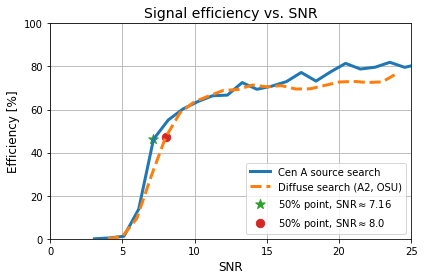

In [158]:
plt.plot(forEff_SNR.index, 100*forEff_SNR.passesCuts_SNR/forEff_SNR.binnedSNR, linewidth = 3, label = "Cen A source search")
# plt.plot(diffuse_EffSNR.snr, 100*diffuse_EffSNR["eff"], label = "Diffuse search (A2, MYL)")
plt.scatter(7.159091, 46.196734, s=100, marker = "*",color = "C2", label=r'50% point, SNR$\approx 7.16$')
plt.plot(diffuse_EffSNR_Brian.snr, 100*diffuse_EffSNR_Brian["a2_eff"],"--", linewidth = 3, label = "Diffuse search (A2, OSU)")
plt.scatter(8.0,100*0.4719, s=70, color="C3",marker = "o", label=r'50% point, SNR$\approx 8.0$')

# plt.xscale('log')
plt.xlabel("SNR", fontsize=12)
plt.ylabel("Efficiency [%]", fontsize=12)
plt.title("Signal efficiency vs. SNR", fontsize=14)
plt.grid()
plt.xlim(0,25)
plt.ylim(0,100)

plt.legend()
plt.tight_layout()
plt.savefig("./plots/CenA_search_SNRefficiency.png", dpi=200)

#### 50% point change

In [80]:
diffuse_EffSNR_Brian.loc[diffuse_EffSNR_Brian.index==4]

,snr,a2_eff,a2_err,a3_eff,a3_err
4,8.0,0.4719,0.0114,0.3603,0.0145


In [102]:
forEff_SNR["eff"] = 100*forEff_SNR.passesCuts_SNR/forEff_SNR.binnedSNR
forEff_SNR.loc[forEff_SNR.eff < 50]
# forEff_SNR

,binnedSNR,passesCuts_SNR,eff
SNR,,,
3.068182,2,0.0,0.000000
4.090909,1727,7.0,0.405327
5.113636,5826,69.0,1.184346
6.136364,3811,526.0,13.802152
7.159091,2511,1160.0,46.196734


#### Put cut line in the SNR vs $C_{sky}$ plot

In [6]:
m = -2080
y = np.linspace(0,1,50);
interc = 20.6-0.54
interc2 = 20.6

x = m*y+interc
x2 = m*y+interc2

In [7]:
# sns.catplot(x="snr", y="corr", data=df2, hue='failsRcut');
sns.lmplot( x="snr", y="corr", data=cuts, fit_reg=False, hue='failsCut', legend=True, palette="Set1", legend_out=False, scatter_kws={"s": 1})
plt.plot(x,y, color="C2", label = "Cen A cut")
plt.plot(x2,y, color="C1", label = "Diffuse cut")


plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')

plt.xlim(0,40)
plt.ylim(1e-4,0.04)
plt.grid()
plt.grid(which='minor', axis='both')
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/SNRvsCsky_CenA.png", dpi=200)


NameError: name 'cuts' is not defined

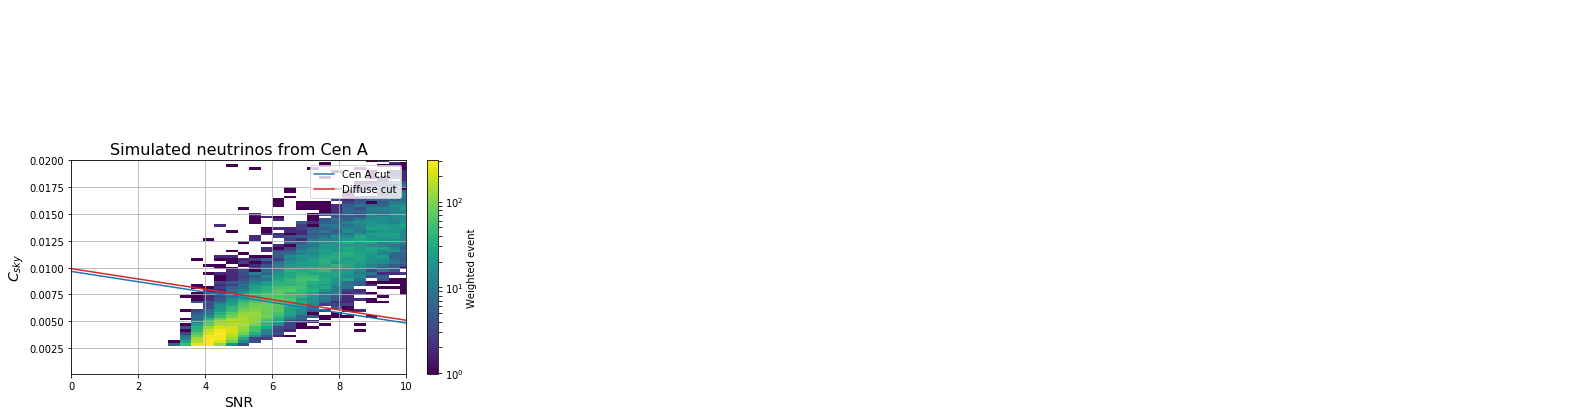

In [13]:
plt.figure(figsize=(7,4))
plt.hist2d(snr_val,corr_val, bins=120, weights=weight,norm=LogNorm());

# plt.hist2d(snr_val,corr_val, bins=420, weights=weight,norm=LogNorm());

plt.colorbar(label="Weighted event" )
plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')
plt.plot(x,y, color="C0", label = "Cen A cut")
plt.plot(x2,y, color="C3", label = "Diffuse cut")

plt.xlim(0,10)
plt.ylim(1e-4,0.02)
plt.grid()
plt.grid(which='minor', axis='both')
plt.legend()
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.tight_layout()
plt.savefig("./plots/SNRvsCsky_CenADiffuse_zoom.png", dpi=200)

## Comments

In [170]:
a=(29.03)/(360*2)
-np.log(a)/-5.96

-0.538745207042544